# Interacting particle solutions of the FPK

One central problem of interest in modelling with Stochastic Differential Equations (SDEs), is solving the Fokker-Planck-Kolmogorov equation (FPK). Given a particle whose state $x$ evolves through time $t$ according to an SDE, the FPK describes how the probability density $p_t(x)$ evolves with time. The FPK is of central interest in many modelling, physical and statistical applications. Unfortunately, with few exceptions such as linear SDEs, the FPK cannot be solved in closed form and must be approximated numerically.

Many numerical solution schemes have been developed for solving the FPK, {cite}`sarkka2019applied` including finite element methods and Monte Carlo simulations. Finite element methods are deterministic and typically depend on discretisations through state-space and time and thus scale poorly with the dimensionality of the state and the region being discretised. On the other hand, Monte Carlo simulations - which amount to simulating paths from the SDE and using these as an empirical approximation of $p_t(x)$ - scale better with dimensionality but due to the finite number of sampled paths they induce significant variance in downstream estimators using these paths. Recently, Maoutsa et. al {cite}`maoutsa2020interacting` have developed a numerical approximation scheme which solves for the FPK by simulating deterministic trajectories of an ODE. This method does not involve a discretisation and scales gracefully to higher dimensions. In addition, it is deterministic and therefore the empirically estimated $p_t(x)$ achieves lower variance.

In [1]:
from IPython.display import HTML, set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')
css_style = open('../../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

## Fokker-Planck-Kolmogorov

We begin by introducing the problem this method is trying to solve. Given an SDE of the form

$$\begin{align}
dx = f(x, t)dt + \sigma(x, t) d\beta
\end{align}$$

with initial distribution $p_0(x)$, drift function $f : \mathbb{R}^D \times \mathbb{R} \to \mathbb{R}^D$ and diffusion function $\sigma : \mathbb{R}^D \times \mathbb{R} \to \mathbb{R}^D$ and a standard Brownian motion $\beta$, the FPK describes the evolution of the distribution $p_t(x)$ of $x$ at time $t$ as

$$\begin{align}
\frac{\partial p_t(x)}{\partial t} = - \sum_{i = 1}^D \frac{\partial}{\partial x_i} [f_i(x, t) p_t(x)] + \frac{1}{2} \sum_{i = 1}^D\sum_{j = 1}^D \frac{\partial^2}{\partial x_i \partial x_j} \left[\sigma_i(x, t) \sigma_j(x, t)^\top p_t(x)\right].
\end{align}$$

Here we will constrain ourselves to the special case where the drift is time-independent $f(x, t) = f(x)$ and the diffusion is constant $\sigma(x, t) = \sigma$. In this case, the FPK can be written in the form

$$\begin{align}
\frac{\partial p_t(x)}{\partial t} = - \nabla \cdot \left[ g(x, t) p_t(x) \right] \text{ where } g(x, t) = f(x)p_t(x) - \frac{\sigma^2}{2} \nabla \log p_t(x).
\end{align}$$

This is a deterministic equation, which can be regarded as the Liouville equation of the dynamical system

$$\begin{align}
\frac{d x}{d t} = g(x, t) \text{ where } x_0 \sim p_0(x).
\end{align}$$

Therefore, if we sample $x_0 \sim p_0(x)$ and evolve this up to time $t$ according to this ODE, we obtain $x_t$ distributed according to $p_t(x)$. The difficulty with this is that in order to evolve $x_0$ according to this ODE, we need access to $g(x, t)$. This itself depends on $p_t(x)$ which is the quantity we are trying to solve for, and do not have direct access to. One way to circumvent this problem is to use [kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation). This method fits a probability distribution $\hat{p}_t(x)$ to the empirical samples $x_t$, and $\hat{p}_t(x)$ is then used as an approximation to $p_t(x)$. However, KDE methods place a restrictive form to the function $\hat{p}_t(x)$. More generally, we can use any arbitrary function $p_t(x; w)$ parametrised using parameters $w$ and use this to approximate $p_t(x)$ using the log-gradient [gradient-log-density estimator](../score-matching/score-matching) (GLD). {cite}`hyvarinen2005estimation` We can also follow a non-parametric approach for modelling $p_t(x)$, however we do not explore this here -- see {cite}`maoutsa2020interacting` for more details on this.

## Score matching objective

Here we recapitulate the GLD. Given data that comes from a distribution $p_t(x)$, the GLD can be used to fit a parametrised distribution $p_t(x; w)$ to $p_t(x)$. In many cases of interest, we may know $p_t(x; w)$ only up to a multiplicative normalising constant

$$\begin{align}
p_t(x; w) = \frac{1}{Z} q_t(x; w).
\end{align}$$

This occurs for example if we use a complicated parametric function $q_t(x; w)$, which we cannot integrate in closed form to determine the normalising constant $Z$. The GLD estimator uses the objective function

$$\begin{align}
J(w) = \frac{1}{2} \int p_t(x) || \psi_t(x; w) - \psi_t(x) ||^2 dx.
\end{align}$$

where $\psi_t(x; w) = \nabla \log p_t(x; w)$ and $\psi_t(x) = \nabla \log p_t(x)$, and estimates the parameters $w$ as the minimiser of $J(w)$

$$\begin{align}
\DeclareMathOperator*{\argmin}{arg\,min}
w_{opt} = \argmin_{w} J(w).
\end{align}$$

[It can be shown](../score-matching/score-matching) that minimising $J(w)$ with respect to $w$ is equivalent to minimising

$$\begin{align}
J(w) = \frac{1}{2} \int p_t(x) \left[ \psi^\top(x; w)\psi(x; w) + 2 \nabla \cdot \psi(x; w)  \right] dx + \text{const}.
\end{align}$$

Unlike the previous form of $J$, this one involves $p_t(x)$ only outside the square brackets. This means that given samples from $p_t(x)$, we can approximate $J$ empirically as

$$\begin{align}
J(w) = \frac{1}{2} \sum_{n = 1}^N \left[ \psi^\top(x_n; w)\psi(x_n; w) + 2 \nabla \cdot \psi(x_n; w) \right] dx \text{ where } x_n \sim p_t(x).
\end{align}$$

## Explicit minimisation of $J$

Choosing a linear in the parameters model

$$\begin{align}
\log p_t(x; w) = \phi^\top(x) w_t + \text{const}.,
\end{align}$$

where $\phi^\top(x) = [\phi_1(x), ..., \phi_K(x)]$ is a collection of $K$ basis functions, and substituting into the gradient-log-density estimator we get

$$\begin{align}
J(w_t) &= \frac{1}{2} \sum_{n = 1}^N \left[ w_t^\top \Psi(x_n)^\top \Psi(x_n) w_t + 2 \sum_{d = 1}^D g_d^\top(x_n) w_t  \right]
\end{align}$$

where $\Psi_{ij}(x) = \partial_i \phi_j(x)$ and $g_{d}^\top(x) = \partial_d^2 \phi^\top(x)$. Note that this modelling choice is slightly different to the one employed in {cite}`maoutsa2020interacting`. In the original work, the authors use parametric functions to model the vector function $\psi_t(x)$, whereas here we have used a parametric function to model the scalar function $\log p_t(x)$. The benefit of the present approach is that it yields (up to a normalising constant) an explicit function for $\log p_t(x)$, whereas the original method in the paper does not. Now, using the fact that $J(w)$ is a quadratic form of $w$, we can find its minimiser in closed form

$$\begin{align}
\DeclareMathOperator*{\argmin}{arg\,min}
w_{t, opt} = - \left(\sum^N_{n = 1} \Psi^\top(x_n) \Psi(x_n) \right)^{-1} \left( \sum_{d = 1}^D \partial_d^2 \phi(x) \right).
\end{align}$$

Note that $\Psi(x_n)$ is a $D \times K$ matrix, where $K$ is the number of  for this matrix to be invertible, we must have $N \geq D$. We can also introduce a regularising term to $J(w)$ to prevent $w_t$ taking extreme values, by modifying the objective to $J(w_t) + \lambda ||w_t||^2$ and obtaining the optimal $w_t$ as

$$\begin{align}
\DeclareMathOperator*{\argmin}{arg\,min}
w_{t, opt} = - \left(\lambda I  + \sum^N_{n = 1} \Psi^\top(x_n) \Psi(x_n)\right)^{-1} \left( \sum_{d = 1}^D \partial_d^2 \phi(x) \right).
\end{align}$$

Lastly, we can substitute $w_{opt}$ in our Liouville equation to obtain the explicit ODE

$$\begin{align}
\frac{d x_n}{d t} = f(x_n) - \frac{\sigma^2}{2} \phi^\top(x_n) w_{t, opt}.
\end{align}$$

<div class='definition'>
    
**Algorithm (Interacting particle FPK simulator)** Given an SDE with drift $f(x)$, diffusion $\sigma$ and initial state distribution $p_0(x)$ the interacting particle simulator produces $N$ approximate samples from $p_t(x)$ by drawing $N$ samples from $x_n \sim p_0(x)$ and evolving them according to the ODE

$$\begin{align}
\frac{d x_n}{d t} = f(x_n) - \frac{\sigma^2}{2} \Psi(x_n) w_{t, opt},
\end{align}$$

where the time-dependent $w_{t, opt}$ is obtained as described above.
    
</div>
<br>

## Interpretation

This algorithm uses $N$ particles to empirically estimate the density $p_t(x)$ while evolving them in tandem. The trajectories of the particles are governed by the drift $f(x_n)$ as well as the function $\Psi(x_n) w$. Since $w$ itself depends on the positions of all particles, it constitutes an interaction term between them. The whole collection of particles determines the empirical estimate of $p_t(x)$, which in turn affects the trajectories of the particles.

## Implementation

Below is an imlpementation of this interacting particle simulator. We first define the basis functions $\phi_k$ which we will use, which will be Exponentiated Quadratic functions.

In [2]:
import tensorflow as tf

import numpy as np
from scipy.integrate import ode as ODE

import matplotlib.pyplot as plt

In [3]:
def EQ(x, locs, scales):
    """
    Exponentiated Quadratic basis functions.
    
    Arguments
    x      : tf.Tensor, shape (N, D)
    locs   : tf.Tensor, shape (K, D)
    scales : tf.Tensor, shape (K, D)
    
    Returns
    Phi    : tf.Tensor, shape (N, K)
    """
    
    # Reshape tensors for broadcasting
    x = x[:, None, :]
    locs = locs[None, :, :]
    scales = scales[None, :, :]
    
    quad = -0.5 * ((x - locs) / scales) ** 2
    quad = tf.reduce_sum(quad, axis=2)
    
    return tf.exp(quad)

We define the helper function `optimal_weights`, which given a set of particles $x$, a set of basis functions `phi` and a regularisation costant `lamda`, computes the optimal weights. For this we use automatic differentiation via `GradientTape.batch_jacobian` and decorate the function using `@tf.function` to avoid retracing.

In [4]:
@tf.function
def optimal_weights(x, phi, lamda):
    
    # Nested gradient tapes for computing first and second order derivatives
    with tf.GradientTape(persistent=True) as tape1:
    
        tape1.watch(x)

        with tf.GradientTape(persistent=True) as tape2:

            tape2.watch(x)

            phi_ = phi(x)

        Psi = tape2.batch_jacobian(phi_, x)
        
    G = tape1.batch_jacobian(Psi, x)
    G = tf.linalg.trace(G)
    G = tf.reduce_sum(G, axis=0)
    
    # Compute [Σ Ψ^Τ Ψ] + λ I
    PsiPsi = tf.einsum('nij, nkj -> ik', Psi, Psi)
    PsiPsi = PsiPsi + 1e-4 * tf.eye(PsiPsi.shape[0], dtype=PsiPsi.dtype)
    
    # Compute optimal weights by solving the system of linear equations
    optimal_weights = - tf.linalg.solve(PsiPsi, G[:, None])[:, 0]
    
    return optimal_weights, Psi, PsiPsi

We also define the convenience function `augmented_drift` which computes the ODE drift $g(x, t)$.

In [5]:
def augmented_drift(x, f, sigma, phi, lamda):
    
    w, Psi, PsiPsi = optimal_weights(x, phi, lamda)
    Phi_w = tf.einsum('nij, i -> nj', Psi, w)
    
    drift = f(x) - 0.5 * sigma ** 2 * Phi_w
    
    return drift

We will apply the interacting particle simulator to the double-well SDE, with drift

$$\begin{align}
f(x) = - c x (x - 1) (x + 1),
\end{align}$$

and corresponding potential

$$\begin{align}
U(x) = - \frac{c}{4} \left(x^4 - 2 x^2\right).
\end{align}$$

In [6]:
def double_well_drift(x, c):
    return - c * x * (x - 1.) * (x + 1.)

There is no closed-form for the density $p_t(x)$ for this drift function. We will therefore simulate the density for a sufficiently long time, and then compare the simulated distribution with the stationary distribution, which we can calculate in closed form {cite}`sarkka2019applied`

$$\begin{align}
\pi(x) = \lim_{t \to \infty} p_t(x) \propto \exp \left(- \frac{2}{\sigma^2} U(x) \right).
\end{align}$$

In [7]:
# Set float64 precision
dtype = tf.float64

# Number of particles, features and problem dimension
N = 1000
K = 10
D = 1

# Initial/final simulation times and step size
t0 = 0.
t1 = 1.
dt = 1e-2

# SDE parameters: double well constant and diffusion sigma
c = 2.
sigma = 1.

# Set basis functions and regularisation constant
locs = tf.cast(tf.linspace(-2., 2., K), dtype=dtype)[:, None]
scales = tf.ones(shape=(K, D), dtype=dtype)

phi = lambda x : EQ(x, locs=locs, scales=scales)
lamda = 1e-4

# Solver tolerance
atol = 1e-4

# Set up the ODE system
f = lambda x : double_well_drift(x, c=c)
r = lambda t, x : augmented_drift(tf.reshape(x, (N, D)), f, sigma, phi, lamda)
g = lambda t, x : tf.reshape(r(t, x), (-1,)).numpy()

# Initial locations of the particles
x0 = np.random.normal(0., 1e0, size=(N, D))

# Set up the ODE solver
ode = ODE(g).set_integrator('vode', atol=atol)
ode = ode.set_initial_value(np.reshape(x0, (-1,)), t0)

# Array to keep track of the trajectries
trajectories = [x0.reshape(-1)]

# Solve ODE forward
while ode.successful and ode.t < t1:
    solution = ode.integrate(ode.t + dt)
    trajectories.append(solution)

trajectories = np.stack(trajectories, axis=0)
trajectories = np.reshape(trajectories, (-1, N, D))

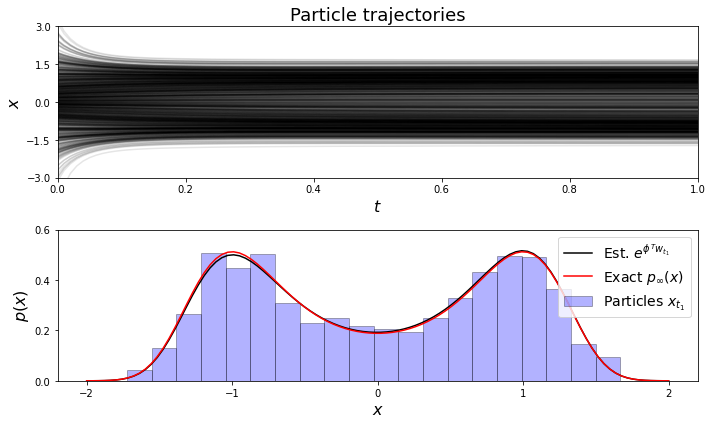

In [10]:
t_plot = np.linspace(t0, t1, trajectories.shape[0])

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(t_plot, trajectories[:, :, 0], color='k', alpha=0.1)

# Plot formatting
plt.title('Particle trajectories', fontsize=18)
plt.xlabel('$t$', fontsize=16)
plt.ylabel('$x$', fontsize=16)
plt.xlim([t0, t1])
plt.ylim([-3, 3])
plt.yticks(np.linspace(-3, 3, 5))

# Plot estimated pt(x) at t = t1
plt.subplot(2, 1, 2)

# Locations to plot pt(x) at
x_plot = np.linspace(-2, 2, 100)[:, None]
x_range = np.max(x_plot) - np.min(x_plot)

# Get optimal weights as given by GLD
w, Psi, _ = optimal_weights(trajectories[-1,  :, :], phi, lamda)

# Compute density estimated via φT w
est_density = np.exp(tf.matmul(phi(x_plot), w[:, None])[:, 0].numpy())
est_density = est_density / np.sum(est_density) * (x_plot.shape[0] / x_range)

# Compute true stationary density (t = infinity limit)
true_density = np.exp(- 2 * c * (0.25 * x_plot ** 4 - 0.5 * x_plot ** 2))
true_density = true_density / np.sum(true_density) * (x_plot.shape[0] / 4)

# Plot particle histogram (t = t1)
plt.hist(trajectories[-1, :, 0],
         density=True,
         bins=20,
         color='b',
         alpha=0.3,
         edgecolor='black',
         label='Particles $x_{t_1}$')

# Plot density estimated by GLD (t = t1)
plt.plot(x_plot,
         est_density,
         color='black',
         label='Est. $e^{\phi^T w_{t_1}}$')

# Plot true stationary density (t = infinity limit)
plt.plot(x_plot,
         true_density,
         color='red',
         label='Exact $p_{\infty}(x)$')

# Format plot
plt.ylim([0.0, 0.6])
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$p(x)$', fontsize=16)
plt.xticks(np.linspace(-2., 2., 5))
plt.yticks(np.linspace(0., 0.6, 4))
plt.legend(loc='upper right', fontsize=14)

plt.tight_layout()
plt.show()

We see that the particle trakectories in this case quickly converge to some equilibrium distribution. This equilibrium distribution matches the exact stationary distribution of the SDE $p_{\infty}(x)$ - both the particle histogram (blue) and the GLD-estimated distribution (black) match the stationary distribution. Note how the particle trajectories themselves are smooth, since the only source of randomness is the initial state distribution. If we were to sample the SDE directly, these samples would involve randomness both due to the initial state distribution as well as the random Brownian motion associated with each path. This means that downstream estimators using these deterministic particles to approximate $p_t(x)$ will have smaller variance than paths sampled directly from the SDE.

## Conclusion

We have seen how the FPK can be recast as a Liouville equation, which can in turn be simulated using the GLD estimator. This method evolves a number of particles with randomly sampled initial conditions and deterministic dynamics. The Liouville equation involves an term involving the particle density, which can be interpreted as an interaction term between the particles. This simulation method can be used to obtain lower-variance empirical estimates of the particle density compared to directly sampling paths from the FPK. Recently, this method has been applied {cite}`song2020score` to training large-scale generative models to high-dimensional SDEs, using Neural Networks.

## References


```{bibliography} ./references.bib
```